## Configure the code
- Import the libraries and configure the dictionary 

In [7]:
import glob
import cv2 
from cv2 import aruco 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

arucoDict = cv2.aruco.Dictionary_get(aruco.DICT_6X6_250)

## Create the Charuco board

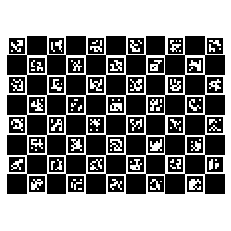

In [8]:
board = aruco.CharucoBoard_create(11, 8, 1, .8, arucoDict)
myboard = board.draw((2000, 2000))

#Show the board
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(myboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()

#Save the board
#cv2.imwrite("charuco.tiff", myboard)

## After create the image, we need to take pictures of it
- Make sure that you take a lot of images with differents angles
- It's important that you have a light source behind your camera
- The pattern must cover most of the image (at least a half)

### Now import the images to the code

In [9]:
images = glob.glob("patternsImages/*jpg")
print("Images uploaded")

Images uploaded


## Fuction to detect the charuto corners

In [10]:
def detectCharucoCorners(images):
    allCorners = []
    allIds = []
    decimator = 0
    #subpixel corner detection criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    
    for image in images:
        print("=> Processing image {0}".format(image))
        frame = cv2.imread(image)
        grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(grayFrame, arucoDict)
        
        # if the corners are valid 
        if len(corners)>0:
            for corner in corners:
                # do the subpixel detection
                cv2.cornerSubPix(grayFrame, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
            
            # returns the 2D position of the chessboard corners from a ChArUco board using the detected Aruco markers
            interpolatedCorners = cv2.aruco.interpolateCornersCharuco(corners, ids, grayFrame, board)
            if interpolatedCorners[1] is not None and interpolatedCorners[2] is not None and len(interpolatedCorners[1]>3) and decimator%1==0:
                allCorners.append(interpolatedCorners[1])
                allIds.append(interpolatedCorners[2])
        decimator += 1
        
    imageSize = grayFrame.shape
    print("Corners are detected successfully!")
    
    return allCorners, allIds, imageSize
    

## Function to calibrate the camera

In [18]:
def calibrateCameraUsingCharuco(allCorners, allIds, imageSize):
    print("STARTING CAMERA CALIBRATION")
    
    initialCameraMatrix = np.array([[ 1000.,    0., imageSize[0]/2.],
                                 [    0., 1000., imageSize[1]/2.],
                                 [    0.,    0.,           1.]])
    initialDistCoeffs = np.zeros((5,1))
    
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    criteria = (cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9)
    
    (ret, cameraMatrix, distortionCoefficients , rotationVectors, translationVectors, 
    stdDevIntrisics, stdDevExtrinsics, reprojectionError)  = cv2.aruco.calibrateCameraCharucoExtended(charucoCorners = allCorners,
                                                                                                      charucoIds = allIds,
                                                                                                      board = board,
                                                                                                      imageSize = imageSize,
                                                                                                      cameraMatrix = initialCameraMatrix,
                                                                                                      distCoeffs = initialDistCoeffs,
                                                                                                      flags = flags,
                                                                                                      criteria = criteria)
    print("CALIBRATION PROCESS DONE!")
    return ret, cameraMatrix, distortionCoefficients, rotationVectors, translationVectors, reprojectionError
    
    
    
    
    
    
    

### Now, we can detect the markers and his corners 
- After this, the we'll have all we need to start the calibration

In [12]:
allCorners, allIds, imageSize = detectCharucoCorners(images)

=> Processing image patternsImages\calibImg01.jpg
=> Processing image patternsImages\calibImg02.jpg
=> Processing image patternsImages\calibImg03.jpg
=> Processing image patternsImages\calibImg04.jpg
=> Processing image patternsImages\calibImg05.jpg
=> Processing image patternsImages\calibImg06.jpg
=> Processing image patternsImages\calibImg07.jpg
=> Processing image patternsImages\calibImg08.jpg
=> Processing image patternsImages\calibImg09.jpg
=> Processing image patternsImages\calibImg10.jpg
=> Processing image patternsImages\calibImg11.jpg
=> Processing image patternsImages\calibImg12.jpg
=> Processing image patternsImages\calibImg13.jpg
=> Processing image patternsImages\calibImg14.jpg
Corners are detected successfully!


In [21]:
ret, cameraMatrix, distCoefficients, rotationVecs, translationVecs, reprojectionError = calibrateCameraUsingCharuco(allCorners, allIds, imageSize)


STARTING CAMERA CALIBRATION
CALIBRATION PROCESS DONE!


array([[1.47187952e+03, 0.00000000e+00, 7.00214048e+02],
       [0.00000000e+00, 1.47187952e+03, 3.10437811e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

#### Camera Matrix:

In [27]:
cameraMatrix

array([[1.47187952e+03, 0.00000000e+00, 7.00214048e+02],
       [0.00000000e+00, 1.47187952e+03, 3.10437811e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

#### Re-projection error:
- "ret" = the mean re-projection error
- "reprojectionError" = vector that contains the error of all images


In [24]:
ret 

0.5679860292288063

In [28]:
reprojectionError

array([[0.43104837],
       [0.71876092],
       [0.46967368],
       [0.67475693],
       [0.78061067],
       [0.47084912],
       [0.52466702],
       [0.4105172 ],
       [0.48190515],
       [0.51152328],
       [0.55011419],
       [0.46858363],
       [0.68556347],
       [0.61422282]])

#### Distortion Parameters

In [25]:
distCoefficients

array([[-1.01179803e+01],
       [ 1.49230858e+02],
       [-9.96330317e-03],
       [ 1.24594214e-02],
       [ 1.40580135e+02],
       [-1.01999426e+01],
       [ 1.49545840e+02],
       [ 1.23627101e+02],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

### To see if its works
- Draw the detected corners in the Charuco:

In [49]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
decimator = 0

allCorners = []
allIds = []

testImage = cv2.imread("patternsImages/calibImg01.jpg")
grayFrame = cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(grayFrame, arucoDict)

imageWithMarkers = cv2.aruco.drawDetectedMarkers(grayFrame,corners, ids)

#Show the image with OpenCV
cv2.imshow("testImage", imageWithMarkers)
cv2.waitKey(0)
cv2.destroyAllWindows()
        
'''# if the corners are valid 
if len(corners) > 0 :
    for corner in corners:
        # do the subpixel detection
        cv2.cornerSubPix(grayFrame, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
            
    # returns the 2D position of the chessboard corners from a ChArUco board using the detected Aruco markers
    interpolatedCorners = cv2.aruco.interpolateCornersCharuco(corners, ids, grayFrame, board)
    if interpolatedCorners[1] is not None and interpolatedCorners[2] is not None and len(interpolatedCorners[1]>3) and decimator%1==0:
        allCorners.append(interpolatedCorners[1])
        allIds.append(interpolatedCorners[2])
    decimator += 1

imageCorners = np.array(allCorners)            
outputImage = cv2.aruco.drawDetectedCornersCharuco(grayFrame, allCorners, allIds)
'''

'# if the corners are valid \nif len(corners) > 0 :\n    for corner in corners:\n        # do the subpixel detection\n        cv2.cornerSubPix(grayFrame, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)\n            \n    # returns the 2D position of the chessboard corners from a ChArUco board using the detected Aruco markers\n    interpolatedCorners = cv2.aruco.interpolateCornersCharuco(corners, ids, grayFrame, board)\n    if interpolatedCorners[1] is not None and interpolatedCorners[2] is not None and len(interpolatedCorners[1]>3) and decimator%1==0:\n        allCorners.append(interpolatedCorners[1])\n        allIds.append(interpolatedCorners[2])\n    decimator += 1\n\nimageCorners = np.array(allCorners)            \noutputImage = cv2.aruco.drawDetectedCornersCharuco(grayFrame, allCorners, allIds)\n'

In [42]:
help(cv2.aruco.interpolateCornersCharuco)

Help on built-in function interpolateCornersCharuco:

interpolateCornersCharuco(...)
    interpolateCornersCharuco(markerCorners, markerIds, image, board[, charucoCorners[, charucoIds[, cameraMatrix[, distCoeffs[, minMarkers]]]]]) -> retval, charucoCorners, charucoIds
    .   * @brief Interpolate position of ChArUco board corners
    .    * @param markerCorners vector of already detected markers corners. For each marker, its four
    .    * corners are provided, (e.g std::vector<std::vector<cv::Point2f> > ). For N detected markers, the
    .    * dimensions of this array should be Nx4. The order of the corners should be clockwise.
    .    * @param markerIds list of identifiers for each marker in corners
    .    * @param image input image necesary for corner refinement. Note that markers are not detected and
    .    * should be sent in corners and ids parameters.
    .    * @param board layout of ChArUco board.
    .    * @param charucoCorners interpolated chessboard corners
    .   